![](img/twitterSpam.jpg "Twitter spam classification")


## problem statement

- Classify tweet into spam/non-spam ( current focus on covid19 related tweet)
- As there is no label data yet, we will use other twitter spam dataset to determine its accuracy and perhaps can create human-- in-the-loop system to constant update and feedback the system



## data source for model training

https://www.kaggle.com/c/utkmls-twitter-spam-detection-competition/data


In [130]:
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer ,TfidfVectorizer
import pandas as pd
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, roc_curve, auc



In [2]:
df = pd.read_csv('data/train.csv')

In [23]:
df.head(10)

,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam,NaN
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality,NaN
5,"#amms Samantha Bee Tries to ATTACK Trump, Inst...",29.0,7.0,389.0,0.0,England,Spam,NaN
6,please don't talk about me like that i'm only ...,0.0,6200000.0,NaN,1.0,"los angeles, ca",Quality,NaN
7,Politicshttps://twitter.com/ngunjiriwambugu/st...,0.0,0.0,0.0,0.0,NaN,Quality,NaN
8,Banking on Brexit: is it time to Invest in the...,530.0,849.0,8288.0,1.0,Kuala Lumpur,Spam,NaN
9,They are serving and protecting #5WordRegrets ...,6601.0,8805.0,10712.0,0.0,"Sheffield, England",Spam,NaN


In [4]:
df.Type.value_counts()

Quality         7454
Spam            7443
South Dakota       2
Name: Type, dtype: int64

In [66]:
## drop unwanted data, exclude it
df = df[ ~ (df['Type']=='South Dakota')].reset_index(drop = True)


## word cloud visualization (spam tweet)

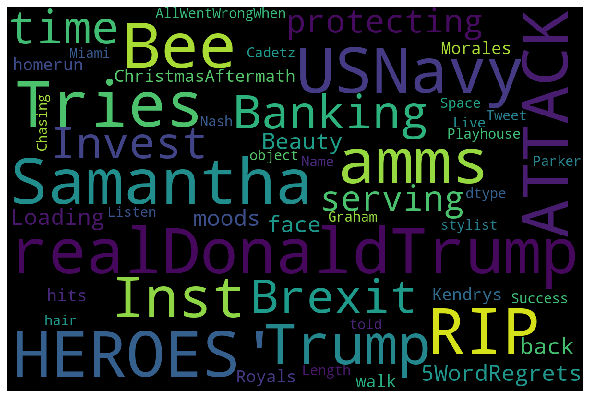

In [127]:
stopwords_set = set(STOPWORDS) 

SELECTED_DATA = df [df['Type']=='Spam' ]['Tweet']

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='black', 
                stopwords = stopwords_set,
                min_font_size = 10).generate( str(SELECTED_DATA )) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## word cloud visualization (non-spam tweet)

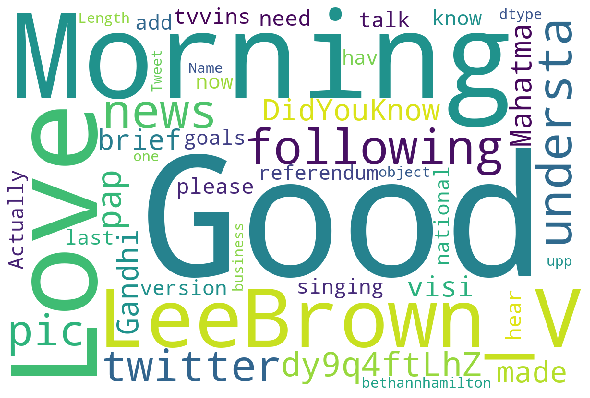

In [73]:
stopwords_set = set(STOPWORDS) 

SELECTED_DATA = df [df['Type']=='Quality' ]['Tweet']

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                stopwords = stopwords_set,
                min_font_size = 10).generate( str(SELECTED_DATA )) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [68]:
#### Custom Function #############


def clean( raw_text ):
    letters_only = re.sub("[^a-zA-Z]", " ", str(raw_text)) # Remove non-letters
    words = letters_only.lower().split()  # Convert to lower case, split into individual words                           
    stops = set(stopwords.words("english"))   # In Python, searching a set is much faster than searching a list, so convert the stop words to a set             
    meaningful_words = [w for w in words if not w in stops]   # Remove stop words
    #meaningful_words = [stemmer.stem(x) for x in meaningful_words ]  #stemmiing malay words
    return ( " ".join( meaningful_words )) # Join the words back into one string separated by space, and return the result.




## text processing

In [74]:
df['clean_tweet'] = ""
df['clean_tweet'] = df['Tweet'].apply(clean)



In [52]:
df['Tweet']  

0                           Good Morning Love  @LeeBrown_V
1                 '@realDonaldTrump @USNavy RIP TO HEROES'
2        Haven't been following the news but I understa...
3        pic.twitter.com/dy9q4ftLhZ What to do with pap...
4        #DidYouKnow ► Mahatma Gandhi made a brief visi...
                               ...                        
14894    #AllWentWrongWhen I told my hair stylist to "g...
14895    They don't have to like you, and you don't hav...
14896    #Miami Graham Nash Live at Parker Playhouse  #...
14897    @bethannhamilton is in the business of one-upp...
14898      Chasing Success  by  Space Cadetz  Listen up...
Name: Tweet, Length: 14899, dtype: object

In [88]:
df['IsSpam'] = df['Type'].apply(lambda x: 1 if x=='Spam'  else  0 )


In [89]:
df['IsSpam']

0        0
1        1
2        0
3        0
4        0
        ..
14892    1
14893    0
14894    1
14895    0
14896    1
Name: IsSpam, Length: 14897, dtype: int64

In [93]:
df['IsSpam'].value_counts()

0    7454
1    7443
Name: IsSpam, dtype: int64

## train test split

In [90]:

X = df['Tweet']   # df.drop(['Type'],axis=1)
y = df['IsSpam']

# X = df[['tenure', 'age','equip']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)





(11917,) (2980,)


## Naive bayes classifier

In [99]:



################################################## NB Classifier ################################################

## build a data processing pipeline
text_clf = Pipeline([('vect', CountVectorizer(max_features = 5000, ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.01)),])

text_clf = text_clf.fit( X_train , y_train)
NB_prediction = text_clf.predict( X_test)
NB_accuracy = np.mean( NB_prediction == y_test )


## Gridsearch on finding optimized model
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
                  'tfidf__use_idf': (True, False),
                  'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit( X_train , y_train)
predicted = gs_clf.predict(X_test)
gs_clf.best_score_
gs_clf.best_params_
gs_NB_accuracy = np.mean(predicted == y_test )

## save the predictive model
joblib.dump(gs_clf, "model/NB_classifier.sav")


C:\Users\Luthe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


['NB_classifier.sav']

In [100]:
gs_NB_accuracy

0.8953020134228188

### NB Classifier -  ROC curve

In [110]:

NB_prediction_proba = text_clf.predict_proba( X_test)[:,1] ## get the positive label (spam) at 2nd column 


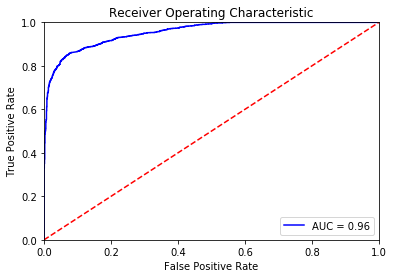

In [114]:

## false positive rate, true positive rate, for ROC
fpr, tpr, threshold = roc_curve(y_test, NB_prediction_proba  )
roc_auc = auc(fpr, tpr)

## ROC plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2) SVM classifier

In [116]:
text_clf_svm = Pipeline([('vect', CountVectorizer(max_features = 5000, ngram_range=(1, 2))),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, random_state=42)),])
    #SGDClassifier(loss='hinge',penalty='l2',alpha=0.001, n_iter=5,random_state=42)),
    
    
text_clf_svm = text_clf_svm.fit( X_train , y_train)
SVM_prediction = text_clf_svm.predict( X_test)
SVM_accuracy = np.mean( SVM_prediction == y_test )


## save the model file
joblib.dump(text_clf_svm, "model/SVM_classifier.sav")


## grid search parameter
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                 'clf-svm__alpha': (1e-2, 1e-3),}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train, data_split['y_train'])
gs_clf_svm.best_score_
gs_clf_svm.best_params_ 
gs_predicted_svm = gs_clf_svm.predict(test)
gs_accuracy = np.mean(gs_predicted_svm == data_split['y_test']) 

C:\Users\Luthe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Luthe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [117]:
SVM_accuracy

0.8835570469798658

## SVM classifier - ROC curve

In [120]:
# SVM_prediction_proba = text_clf_svm.predict_proba( X_test)[:,1] ## get the positive label (spam) at 2nd column 


AttributeError: probability estimates are not available for loss='hinge'

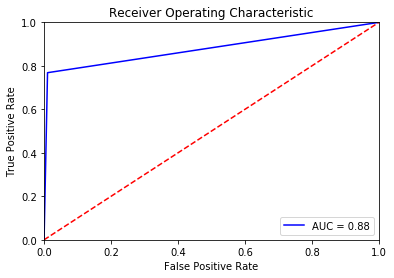

In [119]:

## false positive rate, true positive rate, for ROC
fpr, tpr, threshold = roc_curve(y_test, SVM_prediction )
roc_auc = auc(fpr, tpr)

## ROC plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## test on covid19 related tweet dataset

In [11]:
new_tweet = pd.read_csv('data/corona_tweet_201200408.csv')

In [12]:
new_tweet.head()

,tweetId,isRetweet,time,text,replies,retweets,likes,entries,query_keywords,hashtags,urls,photos,videos
0,1247853862171619328,False,2020-04-08 19:48:39,How many at CNN are taking hydroxychloroquine ...,0,0,0,"{'hashtags': ['#COVID19'], 'urls': [], 'photos...",#Covid19,['#COVID19'],[],[],[]
1,1247853861454393344,False,2020-04-08 19:48:39,Seuuuut ls cas communautaires \n#COVID19\n#Res...,0,0,0,"{'hashtags': ['#COVID19', '#RestezChezVous', '...",#Covid19,"['#COVID19', '#RestezChezVous', '#Daouda_712',...",[],[],[]
2,1247853861387239424,False,2020-04-08 19:48:39,"Bjr @enzo_daoud , pendant cette crise du #COVI...",0,0,0,"{'hashtags': ['#COVID19', '#tonmaillotpourbatt...",#Covid19,"['#COVID19', '#tonmaillotpourbattrelecancer', ...",[],[],[]
3,1247853860879646722,False,2020-04-08 19:48:39,¡Buen Miércoles!\n\n¡Te presentamos la portada...,0,0,0,"{'hashtags': ['#Portada', '#Regional', '#mierc...",#Covid19,"['#Portada', '#Regional', '#miercoles', '#covi...",[],['https://pbs.twimg.com/media/EVFEcbQU4AAfeDB....,[]
4,1247853860753944577,False,2020-04-08 19:48:39,"Interdire, dans ce cas précis = préserver la d...",0,0,0,"{'hashtags': ['#Covid19'], 'urls': [], 'photos...",#Covid19,['#Covid19'],[],[],[]


In [13]:
predicted = text_clf.predict( new_tweet['text'])


In [14]:
predicted

array(['Spam', 'Quality', 'Quality', ..., 'Spam', 'Quality', 'Spam'],
      dtype='<U12')

In [15]:
predicted_df = pd.DataFrame({'text': new_tweet['text'], 'prediction' : predicted })

In [22]:
predicted_df['prediction'].value_counts()

Quality    3578
Spam        622
Name: prediction, dtype: int64

In [19]:
## filter 
predicted_df[predicted_df['prediction']=='Spam']

,text,prediction
0,How many at CNN are taking hydroxychloroquine ...,Spam
14,ها يا ولاد الإصابات بتقل ولا بتزيد.\nلا يافندم...,Spam
20,How many at CNN are taking hydroxychloroquine ...,Spam
33,ها يا ولاد الإصابات بتقل ولا بتزيد.\nلا يافندم...,Spam
40,How many at CNN are taking hydroxychloroquine ...,Spam
...,...,...
4190,Clueless intentional cougher claimed that toda...,Spam
4194,What is forged in the dark can easily shine in...,Spam
4195,#Polski plan pomocy dotyczący skutków koronawi...,Spam
4197,قائدین کی جانب سے جو رد عمل حاصل ہوا ہے، اس کی...,Spam


In [125]:
new_tweet_withLabel = new_tweet.join(  predicted_df['prediction']) 

In [126]:
new_tweet_withLabel.to_csv('result/corona_tweet_201200408_withLabel.csv')

## word cloud visualization (spam tweets, new dataset)

In [131]:
## apply clean text and keep only english text only
predicted_df['clean_text'] = predicted_df['text'].apply(clean)



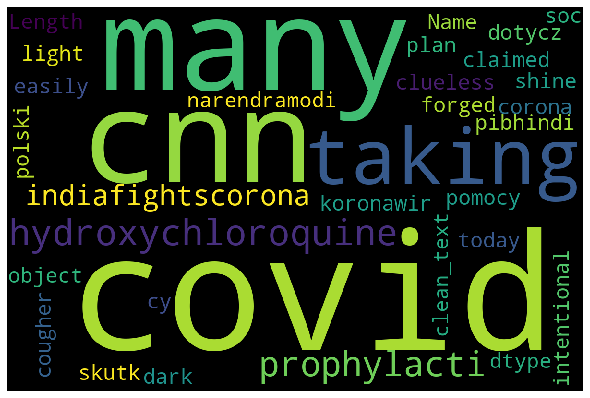

In [132]:
stopwords_set = set(STOPWORDS) 

SELECTED_DATA = predicted_df [predicted_df['prediction']=='Spam' ]['clean_text']

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='black', 
                stopwords = stopwords_set,
                min_font_size = 10).generate( str(SELECTED_DATA )) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## word cloud visualization (non-spam tweets, new dataset)

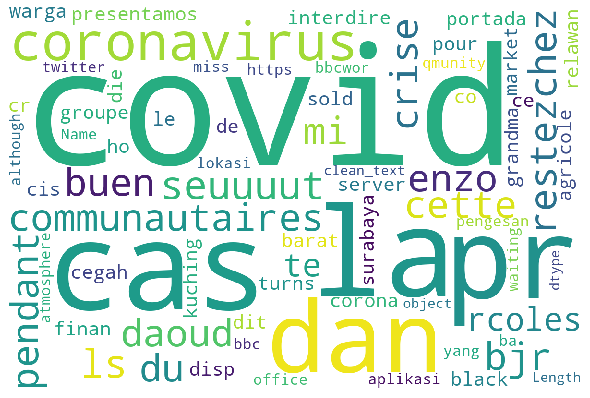

In [133]:
stopwords_set = set(STOPWORDS) 

SELECTED_DATA = predicted_df [predicted_df['prediction']=='Quality' ]['clean_text']

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                stopwords = stopwords_set,
                min_font_size = 10).generate( str(SELECTED_DATA )) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## summary and finding

tweet spam detection can divided into 2 area

- (1) Account level (detect bot, spam account)
- (2) classify spam text only

This work focus on item(2)


- the word distribution quite different in  <font color='red'> kaggle-tweet-training data </font> vs <font color = 'blue'> covid19 tweets data </font> , thus we might need add in new covid19 related labeled data to ensure it able to capture more contextual data
- human evaluation and feedback needed to update the predicted-label

- we can add in emotional features to help further analysis on the spam and non-spam tweets
- other area also the sarcastism 
